In [1]:
import sys  
sys.path.insert(0, '../Libraries/') 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.constants as csts
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import thermodynamics as thermo
import HT_external_convection as extconv
import HT_natural_convection as natconv

## Adding Lake Placid, NY Weather Data

In [2]:
xl = pd.ExcelFile('Climate/April-October-2020.xlsx')

loc = xl.sheet_names[6]
weather = pd.read_excel("Climate/April-October-2020.xlsx",sheet_name=loc,header=0,converters= {'Date time': pd.to_datetime},)
weather = weather.set_index('Date time')
#weather['Name'].head(10)

In [3]:
weather['Solar Radiation'] = weather['Solar Radiation'].fillna(0.0)
weather['Cloud Cover'] = weather['Cloud Cover'].fillna(0.0)
weather['Precipitation'] = weather['Precipitation'].fillna(0.0)
weather['Relative Humidity'] = weather['Relative Humidity'].fillna(0.0)
#weather['Name'].head(-2)

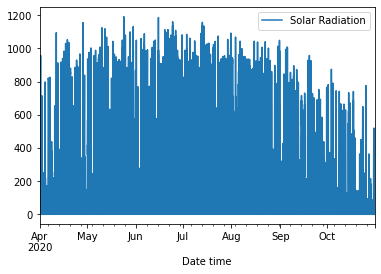

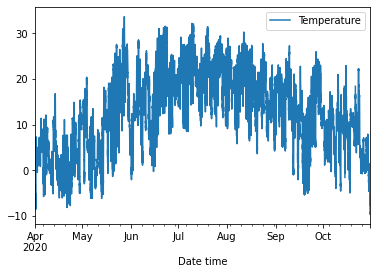

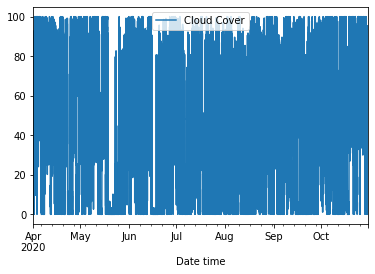

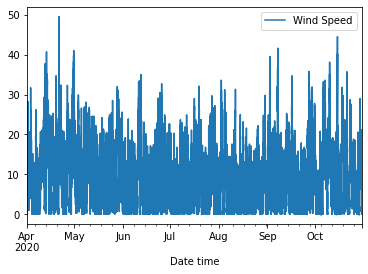

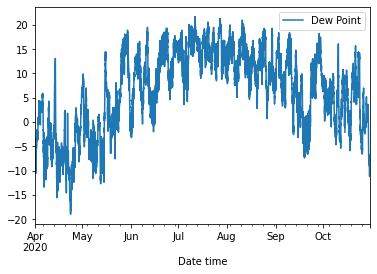

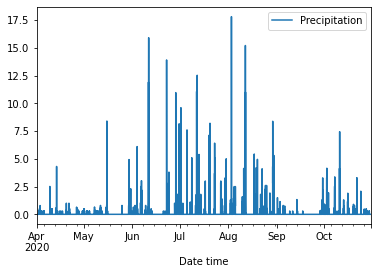

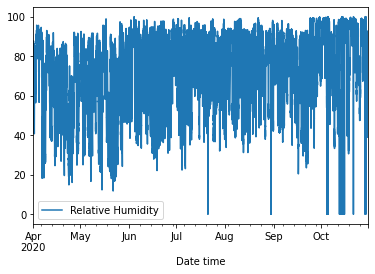

In [4]:
ax0 = weather.plot(y='Solar Radiation')
ax0 = weather.plot(y='Temperature')
ax0 = weather.plot(y='Cloud Cover')
ax0 = weather.plot(y='Wind Speed')
ax0 = weather.plot(y='Dew Point')
ax0 = weather.plot(y='Precipitation')
ax0 = weather.plot(y='Relative Humidity')

In [5]:
t_data = np.arange(0,weather.shape[0]*15*60,15*60)
weather['Wind Speed']      = weather['Wind Speed'].interpolate('cubic')
weather['Temperature']     = weather['Temperature'].interpolate('cubic')
weather['Solar Radiation'] = weather['Solar Radiation'].interpolate('cubic')
weather['Cloud Cover']     = weather['Cloud Cover'].interpolate('cubic')
weather['Dew Point']       = weather['Dew Point'].interpolate('cubic')

U_atm   = np.abs(weather['Wind Speed'][:].to_numpy()/3.6)
T_atm   = weather['Temperature'][:].to_numpy()
q_sun   = weather['Solar Radiation'][:].to_numpy()
cc      = weather['Cloud Cover'][:].to_numpy()/100
cctmp   = np.minimum(cc, np.ones_like(cc))
cc      = np.maximum(cctmp,np.zeros_like(cc))
T_dp    = weather['Dew Point'][:].to_numpy()
RH      = weather['Relative Humidity'][:].to_numpy()

f_U_atm = interp1d(t_data,U_atm,kind='cubic')
f_T_atm = interp1d(t_data,T_atm,kind='cubic')
f_q_sun = interp1d(t_data,q_sun,kind='cubic')
f_CC    = interp1d(t_data,cc,kind='cubic')
f_T_dp  = interp1d(t_data,T_dp,kind='cubic')
f_RH    = interp1d(t_data,RH,kind='cubic')

## Numerical Method Simulation for Warehouse Cooling Requirements

In [10]:
rho = 20. #density of air
C_p = 2500. #specific heat of air
R_wall = 7.27 #m^3K/W
H = 0.3048 #thickness of concrete warehouse walls: m
k = R_wall*H #thermal conductivity of the wall
alpha_s = 0.5 #diffusivity of the sky
eps_sky = 1. #emissivity of the sky
L_w = 70.  #length of the square warehouse: m
h_w = 6.   #height of the warehouse: m
A_wall = 4*(L_w*h_w) #total surface area of the walls
A_roof = L_w**2 #total surface are of the roof
A = A_wall + A_roof  #total surface area of the warehouse exposed to the atmosphere
T_s_lower = 20 #room temp: C

def f(t,T):
    global L_w,k,H,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp,f_RH
    # film temperature between ambient and upper surface
    Tinf = f_T_atm(t)
    Uinf = np.max([f_U_atm(t),0.])
    q_irr = alpha_s*f_q_sun(t)
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    # Wet bulb temp
    T_wb = f_T_atm(t)*np.arctan((0.151977)*(f_RH(t)+8.313659)**0.5 + np.arctan(f_T_atm(t) + f_RH(t)) - np.arctan(f_RH(t)-1.676331) + 0.00391838*((f_RH(t))**(3/2))*np.arctan(0.023101*f_RH(t))-4.686035)
    # sky radiation
    Tdp = f_T_dp(t)
    eps_clear = 0.711 + 0.56*(Tdp/100.) + 0.73*(Tdp/100.)**2
    cc = f_CC(t)/100.
    Ca = 1. + 0.02224*cc + 0.0035*cc**2 + 0.00028*cc**3
    Tsky = (Ca*eps_clear)**0.25*thermo.C2K(Tinf)
    qsky = eps_sky*csts.sigma*(Tsky**4 - thermo.C2K(T[0])**4)
    
    Re = np.abs(Uinf)*L_w/air_f.nu
    Gr = natconv.Gr(beta=air_f.beta,DT=np.abs(T-T_f),D=L_w,nu=air_f.nu)
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(T-T_f),D=L_w,nu=air_f.nu,alpha=air_f.alpha)
    # Forced convection flux
    if Re >0 and (Re <= 5e5):
        airflow = extconv.FlatPlate('laminar','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=L_w,xi=0,Re_xc= 5e5)
        airflow.average(L_w)
        hconv_f = airflow.Nu_ave*air_f.k/L_w
    elif Re > 5e5:
        airflow = extconv.FlatPlate('mixed','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=L_w,xi=0,Re_xc= 5e5)
        airflow.average(L_w)
        hconv_f = airflow.Nu_ave*air_f.k/L_w
    else:
        hconv_f = 0
    #Natural convection flux
    if Ra > 1e4:
        if T[0] >= Tinf:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f.k/L_w
    else:
        hconv_n = 0
    #Total convection flux (here not a function of Ri)
    h = hconv_n + hconv_f
    
    qpp_conv = h*(Tinf - T[0])
    #Conduction flux
    qpp_cond = k*(T[0] - T_s_lower)/H

    return (q_irr+qpp_conv+qsky - qpp_cond)/(rho*C_p)

# Simulation
tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[10.],method='LSODA',t_eval=t_data[mask],max_step=5*60.)

<ipython-input-10-ea8a79794a88>:24: RuntimeWarning: invalid value encountered in power
  T_wb = f_T_atm(t)*np.arctan((0.151977)*(f_RH(t)+8.313659)**0.5 + np.arctan(f_T_atm(t) + f_RH(t)) - np.arctan(f_RH(t)-1.676331) + 0.00391838*((f_RH(t))**(3/2))*np.arctan(0.023101*f_RH(t))-4.686035)
<ipython-input-10-ea8a79794a88>:24: RuntimeWarning: invalid value encountered in double_scalars
  T_wb = f_T_atm(t)*np.arctan((0.151977)*(f_RH(t)+8.313659)**0.5 + np.arctan(f_T_atm(t) + f_RH(t)) - np.arctan(f_RH(t)-1.676331) + 0.00391838*((f_RH(t))**(3/2))*np.arctan(0.023101*f_RH(t))-4.686035)


13069858.62964174

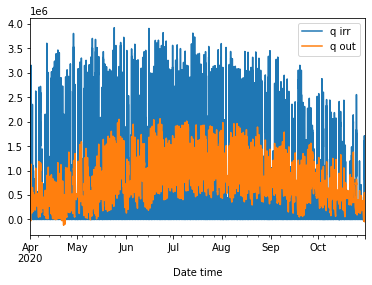

In [7]:
#Ts upper, q out, q irr are assigned to columns in weather panda data
weather['Ts upper'] = sol.y[0]
weather['q out'] = k*A*sol.y[0]/H
weather['q irr'] = alpha_s*weather['Solar Radiation'][:]*A

#Plotting cooling requirement: q out vs solar irradiation heat flux: q irr
ax0 = weather.plot(y='q irr')
weather.plot(y='q out',ax = ax0)

#Total sum of cooling load in J?
weather['q out'].sum()*15*60*1e-6

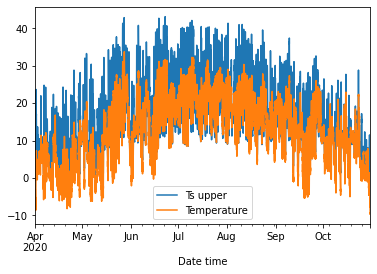

In [8]:
#Scrubbing Atmospheric Temperature Data
np.argwhere(np.isnan(weather['Temperature'][:].to_numpy()))

#Plotting Ts upper versus Atmospheric temperature
ax0 = weather.plot(y='Ts upper')
weather.plot(y='Temperature',ax = ax0)

3630480596.256863

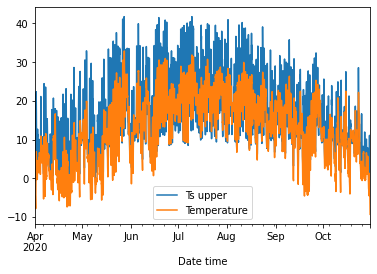

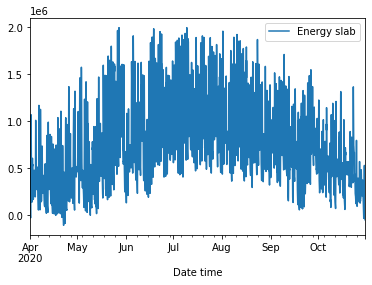

In [9]:
#Resampling weather data
weather_1H = weather.resample("1H").mean()
weather_1H['Energy slab'] = k*A/H*weather_1H['Ts upper']

ax0 = weather_1H.plot(y='Ts upper')
weather_1H.plot(y='Temperature',ax = ax0)

weather_1H.plot(y='Energy slab')

weather_1H['Energy slab'].sum()

# Pipe Heat Transfer
